## Setup

In [24]:
# Working directory.
import os
os.chdir('/Users/andrew.d.tippinmg/Library/CloudStorage/Box-Box/EcoBound')

# Install required libraries if not already installed
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = [
    'geopandas',
    'shapely',
    'contextily',
    'pandasql',
    'matplotlib',
    'seaborn',
    'sklearn',
    'geopy',
    'scipy',
    'shapely',
    'scikit-optimize',
    'dill'
]


for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)


# Now import the packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import numpy as np
from geopy.distance import geodesic
from scipy.optimize import minimize
from shapely.geometry import Point
import json
from skopt.learning import GaussianProcessRegressor
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
import dill


# So we can convert lat/lon to Web Mercator (EPSG:3857)
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# Set up to use a bit of SQL if desired.
#%pip install --upgrade pandasql
from pandasql import sqldf
from sqlalchemy import text

psdf = lambda q: sqldf(q, globals())
print('Packages loaded.')


seed = 271828
random.seed(seed)
np.random.seed(seed)


Installing scikit-optimize...
Packages loaded.


In [25]:
#--------------------------------   
# SET PARAMETERS
#--------------------------------

start_lat = 38.648974 # Supposing we start at WU.
start_lon = -90.310818
degrees_to_km_conversion = 100 # Approximation.
seconds_per_km = 90 # ~90 seconds to travel a kilometer at 25 mph
seconds_to_sample = 600 # 10 minutes
lambda_param = 0.02 # Default value for lambda before tuning.

seconds_per_degree = seconds_per_km*degrees_to_km_conversion
seconds_per_trip = 4*3600 # 4 hours
avail_trips = 50

# Lists of species for mapping and for training lambda.
species_to_plot = ['Agelaius phoeniceus', 'Anas platyrhynchos', 'Branta canadensis', 'Poecile carolinensis', 'Sitta carolinensis']


In [26]:
# To determine training species, use Dan's dataset with adequate mAP.
# Load the JSON file
with open('/Users/andrew.d.tippinmg/Library/CloudStorage/Box-Box/EcoBound/metrics/STL-train_no_overlap-loc-an_full-128-1024_filtered_species_ap0.3.json', 'r') as f:
    data = json.load(f)

# Create a list
training_species = [species for species, value in data.items() if value > 0.3 and species not in species_to_plot] # Don't want to train on our testing species
print(training_species)

['Baeolophus bicolor', 'Cardinalis cardinalis', 'Cyanocitta cristata', 'Dryobates pubescens', 'Haemorhous mexicanus', 'Junco hyemalis', 'Melanerpes carolinus', 'Passer domesticus', 'Spinus tristis', 'Sturnus vulgaris', 'Thryothorus ludovicianus', 'Turdus migratorius', 'Zenaida macroura', 'Zonotrichia albicollis']


## Data collection and organization

In [27]:
# Gather the following:

# Location coordinates (latitude, longitude)
coords_df = pd.read_csv('iNaturalist/densely_sampled_pts.csv')
# Species names
species_names = np.load("iNaturalist/species.npy", allow_pickle=True)
# Initial probabilities
species_probs = np.load("species_priors/STL-train_no_overlap-loc-an_full-128-1024.npy", allow_pickle=True)


# Dan's dataset for training:
dansds = pd.read_csv('AT_intermediate_ds/STL-train_no_overlap-loc-an_full-128-1024_combined.csv')

In [28]:
# Combine densely sampled dataframe. This is our full prior map.
prob_df = pd.DataFrame(species_probs, columns=[f"prob_{name}" for name in species_names])
mapping_df = pd.concat([coords_df, prob_df], axis=1)

# Dan's dataset has only 324 prior probs. Just use those 324 in mapping_df.
# Get the list of 'prob_' columns in both mapping_df and dansds
prob_cols_mapping_df = [col for col in mapping_df.columns if col.startswith("prob_")]
prob_cols_dansds = [col for col in dansds.columns if col.startswith("prob_")]

# Identify columns in mapping_df that start with 'prob_' but aren't in dansds
cols_to_drop = [col for col in prob_cols_mapping_df if col not in prob_cols_dansds]

# Drop those columns from mapping_df
mapping_df = mapping_df.drop(columns=cols_to_drop)


In [29]:
display(mapping_df.head())

,Unnamed: 0,lon,lat,prob_Nycticorax nycticorax,prob_Branta canadensis,prob_Ardea alba,prob_Junco hyemalis,prob_Zonotrichia albicollis,prob_Agelaius phoeniceus,prob_Spinus tristis,...,prob_Cygnus atratus,prob_Setophaga chrysoparia,prob_Phasianus colchicus,prob_Coturnicops noveboracensis,prob_Falco mexicanus,prob_Pyrocephalus rubinus,prob_Hydrocoloeus minutus,prob_Elanoides forficatus,prob_Larus brachyrhynchus,prob_Calcarius ornatus
0,0,-90.092140,38.885166,0.912414,0.696101,0.781059,0.758482,0.881308,0.878555,0.732542,...,0.001796,1.939917e-08,0.000106,4.013482e-09,4.445629e-07,0.000004,6.358576e-07,0.000380,9.910160e-10,6.109774e-13
1,1,-90.093300,38.885166,0.912419,0.696068,0.781076,0.758472,0.881324,0.878566,0.732544,...,0.001796,1.940076e-08,0.000106,4.012739e-09,4.444035e-07,0.000004,6.354999e-07,0.000380,9.902301e-10,6.106536e-13
2,2,-90.094450,38.885166,0.912426,0.696012,0.781104,0.758455,0.881350,0.878585,0.732546,...,0.001797,1.940346e-08,0.000106,4.011423e-09,4.441344e-07,0.000004,6.349136e-07,0.000380,9.889428e-10,6.101122e-13
3,3,-90.095604,38.885166,0.912437,0.695928,0.781146,0.758431,0.881388,0.878615,0.732550,...,0.001799,1.940520e-08,0.000106,4.009189e-09,4.437060e-07,0.000004,6.339957e-07,0.000380,9.869229e-10,6.092249e-13
4,4,-90.096760,38.885166,0.912454,0.695809,0.781204,0.758396,0.881440,0.878659,0.732555,...,0.001801,1.940317e-08,0.000106,4.005200e-09,4.430210e-07,0.000004,6.326192e-07,0.000379,9.838913e-10,6.078020e-13


In [30]:
# Review dataset with ground truth.
display(dansds.info())
display(dansds.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13690 entries, 0 to 13689
Columns: 651 entries, lat to features
dtypes: float64(326), int64(324), object(1)
memory usage: 68.0+ MB


None

,lat,lon,Acanthis flammea,Accipiter striatus,Actitis macularius,Aechmophorus occidentalis,Aegolius acadicus,Agelaius phoeniceus,Aix galericulata,Aix sponsa,...,prob_Vireo philadelphicus,prob_Vireo solitarius,prob_Xanthocephalus xanthocephalus,prob_Xema sabini,prob_Zenaida asiatica,prob_Zenaida macroura,prob_Zonotrichia albicollis,prob_Zonotrichia leucophrys,prob_Zonotrichia querula,features
0,38.456100,-90.459100,0,0,0,0,0,0,0,0,...,0.026101,0.018709,0.000060,0.000012,0.000404,0.649283,0.431496,0.197917,0.003507,[7.00102091e-01 9.33205664e-01 0.00000000e+00 ...
1,38.456100,-90.211553,0,0,0,0,0,1,0,0,...,0.010361,0.007766,0.000020,0.000023,0.000029,0.436296,0.125590,0.086203,0.000781,[0.47471797 0.2928708 0.43236136 0. 1...
2,38.456123,-90.417752,0,0,0,0,0,0,0,0,...,0.044816,0.039105,0.000142,0.000032,0.001048,0.733928,0.537294,0.250197,0.003905,[6.59774959e-01 8.28878284e-01 0.00000000e+00 ...
3,38.456156,-90.305489,0,0,0,0,0,1,0,0,...,0.071421,0.077306,0.000260,0.000096,0.001545,0.788521,0.561326,0.275528,0.002574,[5.48279226e-01 6.04357600e-01 1.08812228e-01 ...
4,38.456177,-90.306765,0,0,0,0,0,0,0,0,...,0.069893,0.075588,0.000238,0.000086,0.001493,0.790999,0.564594,0.273933,0.002436,[0.54946125 0.60460156 0.10361312 0. 0...


In [31]:
# Unpack the features.
# Step 1: Convert the string to arrays
dansds["features_parsed"] = dansds["features"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Step 2: Convert to 2D array
features_array = np.vstack(dansds["features_parsed"].values)

# Step 3: Create new columns
n_features = features_array.shape[1]
feature_col_names = [f"feature_{i}" for i in range(n_features)]
features_df = pd.DataFrame(features_array, columns=feature_col_names, index=dansds.index)

# Step 4: Merge into main DataFrame (optional: drop original column)
analytic_df = pd.concat([dansds, features_df], axis=1)

In [32]:
analytic_df.head()

,lat,lon,Acanthis flammea,Accipiter striatus,Actitis macularius,Aechmophorus occidentalis,Aegolius acadicus,Agelaius phoeniceus,Aix galericulata,Aix sponsa,...,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255
0,38.456100,-90.459100,0,0,0,0,0,0,0,0,...,0.628149,0.332617,0.0,0.083826,0.067636,0.211539,0.551783,0.528964,0.825971,0.384155
1,38.456100,-90.211553,0,0,0,0,0,1,0,0,...,0.140578,0.436005,0.0,0.142638,0.544891,0.140889,0.677561,0.157090,0.700919,0.019670
2,38.456123,-90.417752,0,0,0,0,0,0,0,0,...,0.540910,0.369472,0.0,0.025300,0.000000,0.198898,0.432071,0.446659,0.643445,0.318939
3,38.456156,-90.305489,0,0,0,0,0,1,0,0,...,0.299713,0.421251,0.0,0.000000,0.096481,0.163948,0.460423,0.272196,0.189698,0.138631
4,38.456177,-90.306765,0,0,0,0,0,0,0,0,...,0.302270,0.418217,0.0,0.000000,0.093224,0.164319,0.460713,0.274045,0.189306,0.140543


## Main search loop

In [33]:

def search_loop_multi(
    species_list: list,
    method: str = "random",
    verbose: bool = True,
    sampds: pd.DataFrame = analytic_df,
    extrastr: str = "",
    lambda_val = lambda_param
):
    """
    Active‐sampling loop over multiple species at once.
    Sampling for 'uncertainty' or 'costaware' uses the *average*
    uncertainty across species_list.
    Records final model predictions, mAP, and AUC per species.
    """
    from sklearn.linear_model import LogisticRegression

    # -- Initialize globals if needed --
    global all_map_scores, all_auc_scores, all_weights
    if 'all_map_scores' not in globals():
        all_map_scores = {}
    if 'all_auc_scores' not in globals():
        all_auc_scores = {}
    if 'all_weights' not in globals():
        all_weights = {}
    trip_stops = {}

    # Prepare nested dicts for each species & method
    method_key = f"{method}{extrastr}"
    for sp in species_list:
        all_map_scores.setdefault(sp, {}).setdefault(method_key, [])
        all_auc_scores.setdefault(sp, {}).setdefault(method_key, [])
        all_weights.setdefault(sp, {})[method_key] = None

    # 1) initialize posterior & uncertainty columns for each species
    for sp in species_list:
        pcol = f"posterior_{method}_{sp}{extrastr}"
        ucol = f"uncertainty_{method}_{sp}{extrastr}"
        sampds[pcol] = sampds[f"prob_{sp}{extrastr}"]
        sampds[ucol] = 0.5 - (0.5 - sampds[pcol]).abs()

    # 2) compute avg‐uncertainty column
    ucols = [f"uncertainty_{method}_{sp}{extrastr}" for sp in species_list]
    sampds[f"avg_uncertainty_{method}{extrastr}"] = sampds[ucols].fillna(0).mean(axis=1)

    # keep track of where we sample
    sampled_indices = []
    for trip in range(avail_trips):
        for sp in species_list:
            trip_stops.setdefault(sp, {})
            trip_stops[sp][trip] = []

        if verbose:
            print(f"\n--- Trip {trip+1}/{avail_trips} ({method}) ---")

        # reset trip
        cur_lat, cur_lon = start_lat, start_lon
        remaining_seconds = seconds_per_trip

        # update distance & sample_time
        sampds['distance'] = np.sqrt((sampds['lon']-cur_lon)**2 + (sampds['lat']-cur_lat)**2)
        sampds['sample_time'] = sampds['distance']*seconds_per_degree + seconds_to_sample

        # restrict to reachable & unsampled
        reachable = sampds[
            (sampds['sample_time'] <= remaining_seconds) &
            (~sampds.index.isin(sampled_indices))
        ].copy()
        if reachable.empty:
            if verbose: print(" No reachable points, skipping trip.")
            continue

        # inner sampling loop
        while remaining_seconds > 0 and not reachable.empty:
            if method == "random":
                pick = reachable.sample(n=1, random_state=seed).iloc[0]
            else:
                # use avg‐uncertainty for ranking
                if method == "uncertainty":
                    score = reachable[f"avg_uncertainty_{method}{extrastr}"]
                else:  # costaware
                    score = reachable[f"avg_uncertainty_{method}{extrastr}"] \
                          - lambda_val * reachable['distance']
                pick = reachable.loc[[score.idxmax()]].iloc[0]

            idx = pick.name
            sampled_indices.append(idx)

            # move there
            cur_lat, cur_lon = pick['lat'], pick['lon']
            remaining_seconds -= pick['sample_time']

            for sp in species_list:
                trip_stops[sp][trip].append({
                    "index": idx,
                    "lat": cur_lat,
                    "lon": cur_lon
                })

            for sp in species_list:
                sampds.loc[idx, f"posterior_{method}_{sp}{extrastr}"] = pick[sp]

            # recompute reachable
            reachable = reachable.drop(idx)
            reachable['distance'] = np.sqrt((reachable['lon']-cur_lon)**2 + (reachable['lat']-cur_lat)**2)
            reachable['sample_time'] = reachable['distance']*seconds_per_degree + seconds_to_sample
            reachable = reachable[reachable['sample_time'] <= remaining_seconds]

        # --- end inner loop: now fit models & update posteriors/uncertainties ---
        sampled_df = sampds.loc[sampled_indices]
        loc_cols = [c for c in sampds.columns if c.startswith('feature_')]

        for sp in species_list:
            X = sampled_df[loc_cols]
            y = sampled_df[sp].dropna()
            X = X.loc[y.index]

            # drop any NaNs
            if X.isna().any().any():
                clean = X.dropna().index
                X = X.loc[clean]
                y = y.loc[clean]

            # skip species with only one class
            if y.nunique() < 2:
                if verbose:
                    print(f"  Skipping {sp} — only one class in samples.")
                all_map_scores[sp][method_key].append(np.nan)
                all_auc_scores[sp][method_key].append(np.nan)
                continue

            # fit logistic regression
            model = LogisticRegression(solver='lbfgs', max_iter=1000)
            model.fit(X, y)

            all_weights[sp][method_key] = model

            # predict on all
            X_all = sampds[loc_cols]
            p_all = model.predict_proba(X_all)[:, 1]
            sampds[f"posterior_{method}_{sp}{extrastr}"] = p_all
            sampds[f"uncertainty_{method}_{sp}{extrastr}"] = 0.5 - np.abs(0.5 - p_all)

            mask = ~sampds[sp].isna()
            mAP = average_precision_score(sampds.loc[mask, sp], p_all[mask])
            try:
                AUC = roc_auc_score(sampds.loc[mask, sp], p_all[mask])
            except ValueError:
                AUC = np.nan

            all_map_scores[sp][method_key].append(mAP)
            all_auc_scores[sp][method_key].append(AUC)

        sampds[f"avg_uncertainty_{method}{extrastr}"] = sampds[ucols].mean(axis=1)

    return all_weights, all_map_scores, all_auc_scores, trip_stops



## Run for species of interest. Visualize results.

In [38]:
# Loop over sampling methods.
sampling_methods = ["random", "uncertainty", "costaware"]

# Dictionaries to hold results for each method
all_weights = {}
all_map_scores = {}
all_auc_scores = {}
trip_stops = {}

for method in sampling_methods:
    print(f"\nRunning method: {method}")
    
    weights, map_scores, auc_scores, trip_stops_out = search_loop_multi(
        species_list=species_to_plot,
        method=method,
        verbose=True,
        sampds=analytic_df,
        lambda_val = -0.0002
        # Here, pushing the same lambda value for comparability.
    )
    
    all_weights[method] = weights
    all_map_scores[method] = map_scores
    all_auc_scores[method] = auc_scores
    trip_stops[method] = trip_stops_out



Running method: random

--- Trip 1/50 (random) ---
  Skipping Agelaius phoeniceus — only one class in samples.
  Skipping Anas platyrhynchos — only one class in samples.
  Skipping Branta canadensis — only one class in samples.

--- Trip 2/50 (random) ---

--- Trip 3/50 (random) ---

--- Trip 4/50 (random) ---

--- Trip 5/50 (random) ---

--- Trip 6/50 (random) ---

--- Trip 7/50 (random) ---

--- Trip 8/50 (random) ---

--- Trip 9/50 (random) ---

--- Trip 10/50 (random) ---

--- Trip 11/50 (random) ---

--- Trip 12/50 (random) ---

--- Trip 13/50 (random) ---

--- Trip 14/50 (random) ---

--- Trip 15/50 (random) ---

--- Trip 16/50 (random) ---

--- Trip 17/50 (random) ---

--- Trip 18/50 (random) ---

--- Trip 19/50 (random) ---

--- Trip 20/50 (random) ---

--- Trip 21/50 (random) ---

--- Trip 22/50 (random) ---

--- Trip 23/50 (random) ---

--- Trip 24/50 (random) ---

--- Trip 25/50 (random) ---

--- Trip 26/50 (random) ---

--- Trip 27/50 (random) ---

--- Trip 28/50 (random) 

In [39]:
# Save point 2.
with open("AT_logisticversion_ckpt2.pkl", "wb") as f:
    dill.dump_session(f)

In [42]:
def plot_map_progression_all_species(species_list, map_scores_dict, auc_scores_dict, df, methods, color_palette="colorblind"):
    """
    Plot per-species mAP and then average mAP and AUC over all species.
    """
    sns.set(style="whitegrid")
    palette = sns.color_palette(color_palette, n_colors=len(methods))

    # -------------------------
    # Per-species mAP plots
    # -------------------------
    for species_name in species_list:
        plt.figure(figsize=(10, 6))

        for i, method in enumerate(methods):
            try:
                scores = map_scores_dict[species_name][method]
            except KeyError:
                print(f"Warning: Missing data for species '{species_name}' and method '{method}'")
                continue

            plt.plot(
                range(1, len(scores) + 1),
                scores,
                label=method.capitalize(),
                color=palette[i],
                marker="o",
                linewidth=2
            )

        # Reference line from prior probability
        prob_col = f"prob_{species_name}"
        if prob_col in df.columns:
            y_true = df[species_name]
            y_prob = df[prob_col]
            mask = ~y_true.isna() & ~y_prob.isna()
            try:
                baseline_map = average_precision_score(y_true[mask], y_prob[mask])
                plt.axhline(y=baseline_map, color="gray", linestyle="--", linewidth=2,
                            label=f"Prior mAP = {baseline_map:.4f}")
            except ValueError:
                pass

        plt.title(f"Sampling Method Comparison for {species_name.replace('_', ' ')}", fontsize=16, weight='bold')
        plt.xlabel("Trip Number", fontsize=14)
        plt.ylabel("Mean Average Precision (mAP)", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title="Sampling Method", fontsize=12, title_fontsize=13)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # -------------------------
    # Average mAP across species (with reference line)
    # -------------------------
    plt.figure(figsize=(10, 6))
    prior_maps = []

    for i, method in enumerate(methods):
        all_curves = [map_scores_dict[sp][method] for sp in species_list if method in map_scores_dict.get(sp, {})]
        max_len = max(len(curve) for curve in all_curves)
        padded = [np.pad(curve, (0, max_len - len(curve)), constant_values=np.nan) for curve in all_curves]
        mean_curve = np.nanmean(padded, axis=0)
        plt.plot(range(1, len(mean_curve)+1), mean_curve,
                 label=method.capitalize(), color=palette[i],
                 marker="o", linewidth=2)

    # Compute and add reference line for average prior mAP
    for sp in species_list:
        prob_col = f"prob_{sp}"
        if prob_col in df.columns and sp in df.columns:
            y_true = df[sp]
            y_prob = df[prob_col]
            mask = ~y_true.isna() & ~y_prob.isna()
            try:
                prior_maps.append(average_precision_score(y_true[mask], y_prob[mask]))
            except ValueError:
                pass

    if prior_maps:
        mean_prior_map = np.mean(prior_maps)
        plt.axhline(mean_prior_map, color="gray", linestyle="--", linewidth=2,
                    label=f"Avg. Prior mAP = {mean_prior_map:.4f}")

    plt.title("Logistic: Average mAP over Species", fontsize=16, weight='bold')
    plt.xlabel("Trip Number", fontsize=14)
    plt.ylabel("Mean Average Precision (mAP)", fontsize=14)
    plt.legend(title="Sampling Method", fontsize=12, title_fontsize=13)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.ylim([0.2,0.36])
    plt.show()

    # -------------------------
    # Average AUC across species (with reference line)
    # -------------------------
    plt.figure(figsize=(10, 6))
    prior_aucs = []

    for i, method in enumerate(methods):
        all_curves = [auc_scores_dict[sp][method] for sp in species_list if method in auc_scores_dict.get(sp, {})]
        max_len = max(len(curve) for curve in all_curves)
        padded = [np.pad(curve, (0, max_len - len(curve)), constant_values=np.nan) for curve in all_curves]
        mean_curve = np.nanmean(padded, axis=0)
        plt.plot(range(1, len(mean_curve)+1), mean_curve,
                 label=method.capitalize(), color=palette[i],
                 marker="o", linewidth=2)

    # Compute and add reference line for average prior AUC
    for sp in species_list:
        prob_col = f"prob_{sp}"
        if prob_col in df.columns and sp in df.columns:
            y_true = df[sp]
            y_prob = df[prob_col]
            mask = ~y_true.isna() & ~y_prob.isna()
            try:
                prior_aucs.append(roc_auc_score(y_true[mask], y_prob[mask]))
            except ValueError:
                pass

    if prior_aucs:
        mean_prior_auc = np.mean(prior_aucs)
        plt.axhline(mean_prior_auc, color="gray", linestyle="--", linewidth=2,
                    label=f"Avg. Prior AUC = {mean_prior_auc:.4f}")

    plt.title("Average AUC over Species", fontsize=16, weight='bold')
    plt.xlabel("Trip Number", fontsize=14)
    plt.ylabel("AUC", fontsize=14)
    plt.legend(title="Sampling Method", fontsize=12, title_fontsize=13)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()




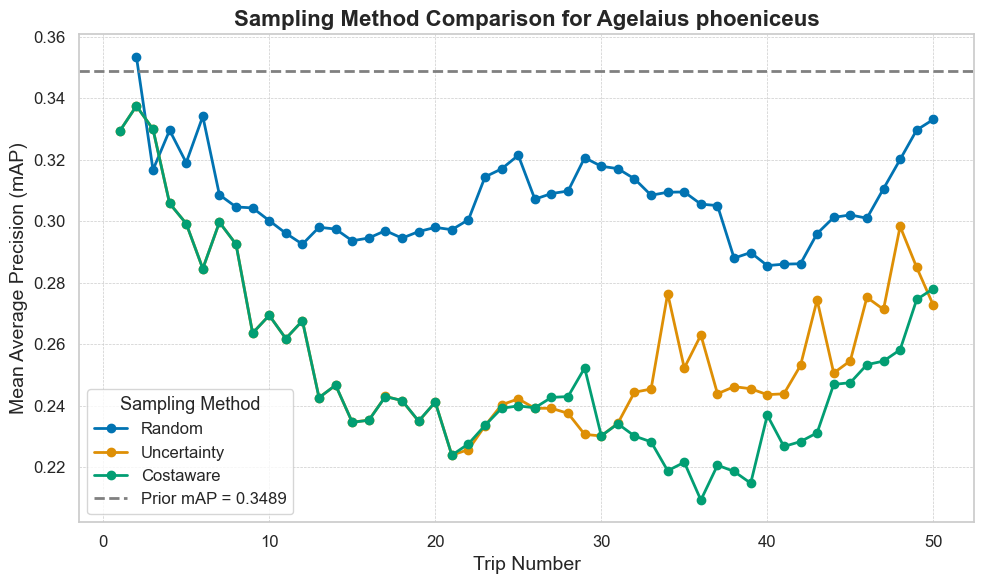

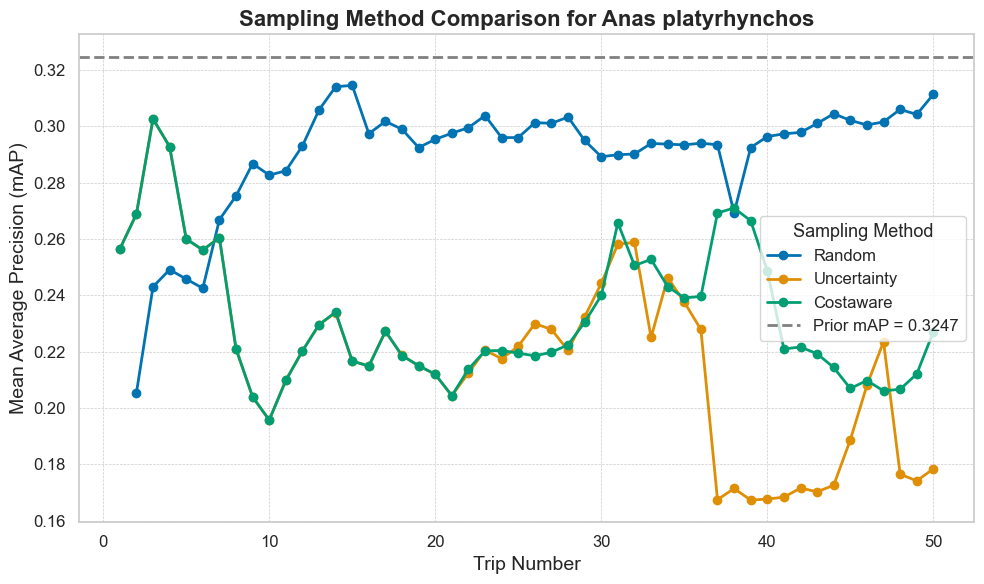

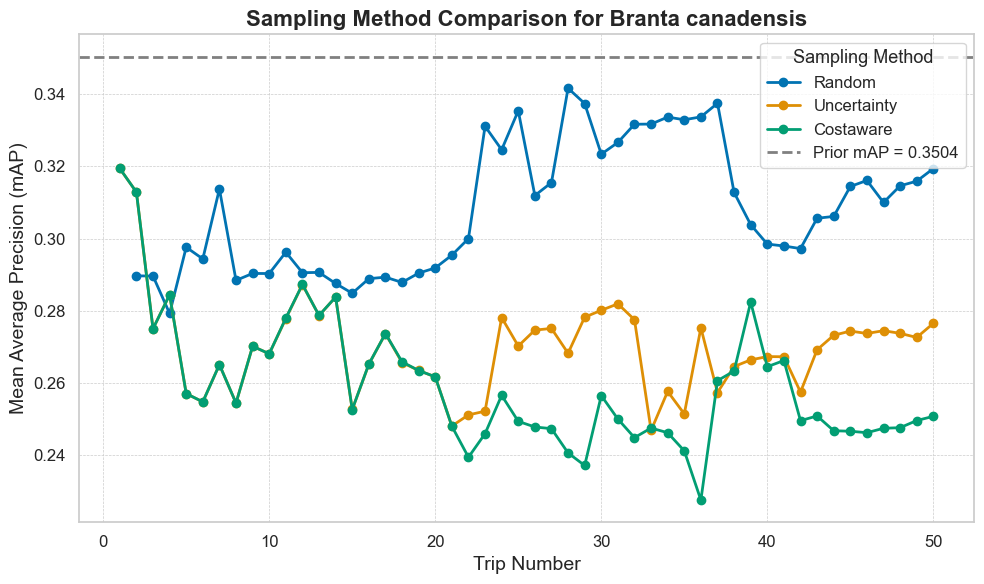

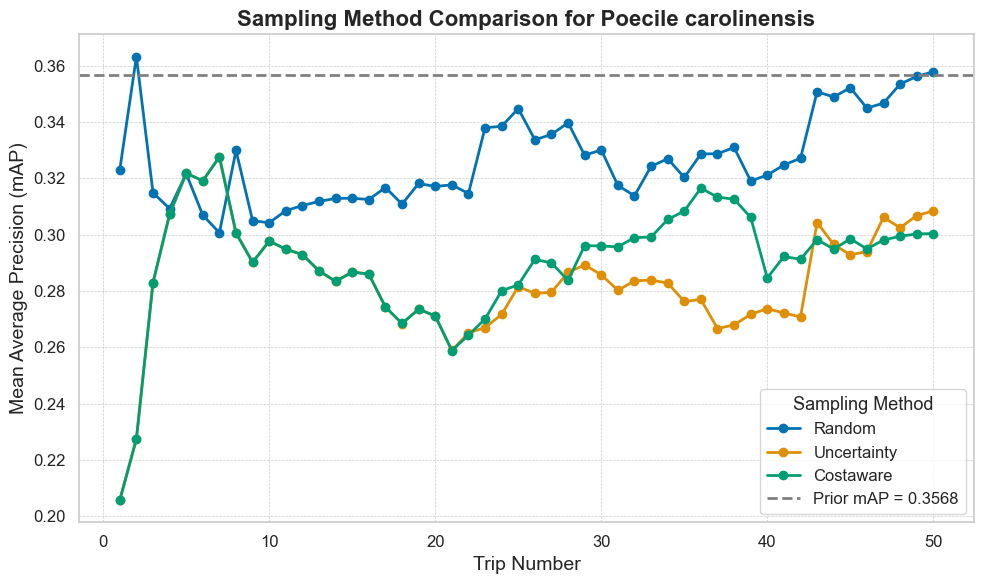

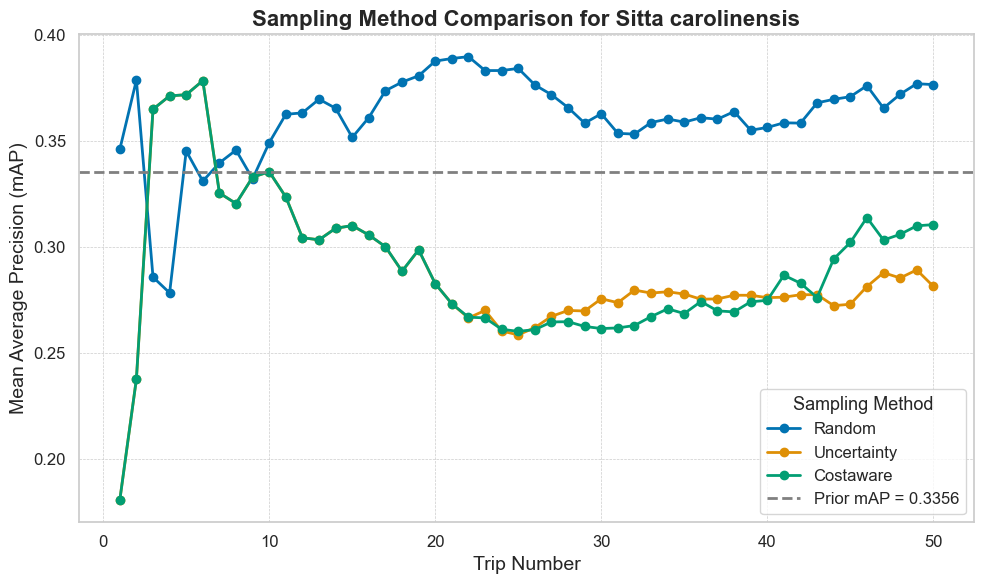

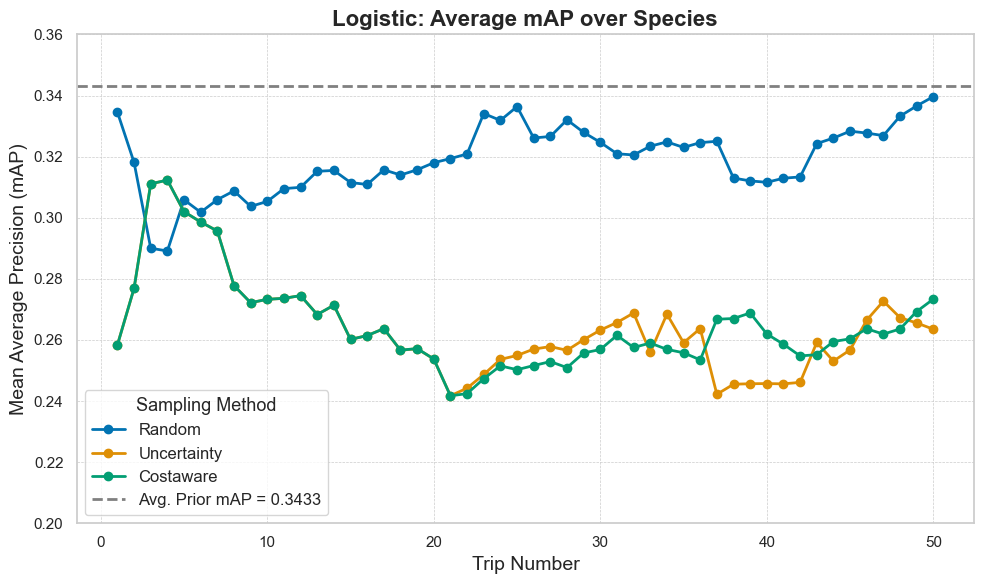

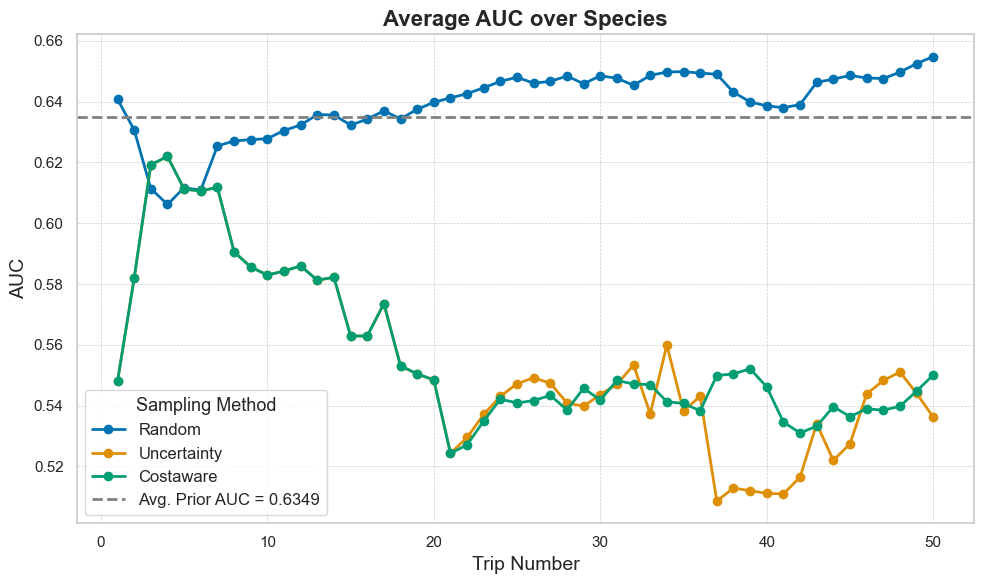

In [43]:
plot_map_progression_all_species(
    species_list=species_to_plot,
    map_scores_dict=all_map_scores,
    auc_scores_dict=all_auc_scores,
    df=analytic_df,
    methods=sampling_methods
)
